In [1]:
from desc.objectives import ObjectiveFunction
from desc.objectives import (
    LCFSBoundaryR,
    LCFSBoundaryZ,
    LambdaGauge,
    LambdaPoincare,
    FixedPressure,
    FixedIota,
    FixedPsi,
    PoincareBoundaryR,
    PoincareBoundaryZ,
)
from desc.objectives import RadialForceBalance, HelicalForceBalance, Energy
from desc.basis import ZernikePolynomial, FourierZernikeBasis,FourierZernike_to_PoincareZernikePolynomial
from desc.transform import Transform
from desc.equilibrium import EquilibriaFamily, Equilibrium
from desc.plotting import plot_1d,plot_2d,plot_comparison
from desc.optimize import Optimizer
from desc.perturbations import perturb,optimal_perturb
import numpy as np
from desc.geometry import ZernikeRZToroidalSection
%matplotlib inline
from desc.utils import copy_coeffs

DESC version 0.4.13+421.g6892d38.dirty, using JAX backend, jax version=0.2.25, jaxlib version=0.1.76, dtype=float64
Using device: CPU, with 22.82 GB available memory


In [2]:
def get_eq_poin(eq):

    Rlmn = []
    Zlmn = []
    modes_R = []
    modes_Z = []
    
    lm_pairs=[]
    for i,mode in enumerate(eq.R_basis.modes):
        if mode[-1] < 0:
            pass # we do not want the sin(zeta) modes
        else:
            if (mode[0],mode[1]) not in lm_pairs:
                lm_pairs.append((mode[0],mode[1]))
                l=mode[0]
                m=mode[1]
                inds = np.where(np.logical_and(eq.R_basis.modes[:,0] == l,eq.R_basis.modes[:,1] == m ))[0]
                SUM = np.sum(eq.R_lmn[inds])
                Rlmn.append(SUM)
                modes_R.append([l,m])
    lm_pairs=[]
    for i,mode in enumerate(eq.Z_basis.modes):
        if mode[-1] < 0:
            pass # we do not want the sin(zeta) modes
        else:
            if (mode[0],mode[1]) not in lm_pairs:
                lm_pairs.append((mode[0],mode[1]))
                l=mode[0]
                m=mode[1]
                inds = np.where(np.logical_and(eq.Z_basis.modes[:,0] == l,eq.Z_basis.modes[:,1] == m ))[0]
                SUM = np.sum(eq.Z_lmn[inds])
                Zlmn.append(SUM)
                modes_Z.append([l,m])
    
    
    surf = ZernikeRZToroidalSection(R_lmn=Rlmn,
                                modes_R=modes_R,
                                Z_lmn=Zlmn,
                                modes_Z=modes_Z,
                               )
    eq_poin = Equilibrium(surface=surf,
                 pressure=eq.pressure,
                 iota=eq.iota,
                 Psi=eq.Psi, # flux (in Webers) within the last closed flux surface
                 NFP=eq.NFP, # number of field periods
                 L=eq.L, # radial spectral resolution
                 M=eq.M, # poloidal spectral resolution
                 N=eq.N, # toroidal spectral resolution 
                 L_grid=eq.L_grid, # real space radial resolution, slightly oversampled
                 M_grid=eq.M_grid, # real space poloidal resolution, slightly oversampled
                 N_grid=eq.N_grid, # real space toroidal resolution
                 sym=True, # explicitly enforce stellarator symmetry
                 bdry_mode='poincare'
                )
    
    
    
    return eq_poin#,L_lmn,L_basis

In [3]:
# work with a simple SOLOVEV and LOOK AT THE A matrix

(<Figure size 864x720 with 6 Axes>,
 array([<AxesSubplot:title={'center':'$\\zeta \\cdot NFP/2\\pi = 0.000$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <AxesSubplot:title={'center':'$\\zeta \\cdot NFP/2\\pi = 0.167$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <AxesSubplot:title={'center':'$\\zeta \\cdot NFP/2\\pi = 0.333$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <AxesSubplot:title={'center':'$\\zeta \\cdot NFP/2\\pi = 0.500$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <AxesSubplot:title={'center':'$\\zeta \\cdot NFP/2\\pi = 0.667$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <AxesSubplot:title={'center':'$\\zeta \\cdot NFP/2\\pi = 0.833$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>],
       dtype=object))

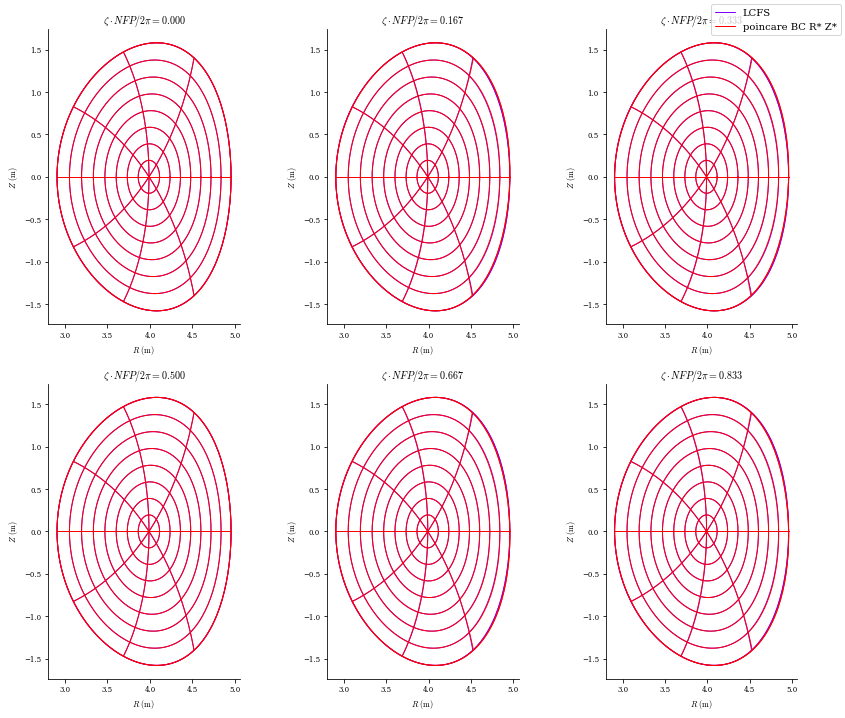

In [4]:
# currently does not work with axisymmetry...
eq = EquilibriaFamily.load(load_from='../examples/DESC/SOLOVEV_output.h5')[-1]
# eq = EquilibriaFamily.load(load_from='SOLOVEV/SOLOVEV_simple_output.h5')[-1] # does it not properly enforce if the constraint would be higher F err? does not seem to make sense...
eq = EquilibriaFamily.load(load_from='SOLOVEV/SOLOVEV_vac_output.h5')[-1]
eq_poin = get_eq_poin(eq)
eq_poin.L_lmn = eq.L_lmn
eq_poin.change_resolution(eq_poin.L,eq_poin.M,1) # must be certain bases are the same before assigning eq.X_lmn
eq_poin.R_lmn[1:4] = eq_poin.R_lmn[1:4]+0.005
plot_comparison(eqs=[eq,eq_poin],labels=['LCFS','poincare BC R* Z*'])

Building constraint: poincare R
Building constraint: poincare Z
Building constraint: lambda poincare
Building constraint: lambda gauge
Building constraint: fixed-pressure
Building constraint: fixed-iota
Building constraint: fixed-Psi
Building objective: radial force
Precomputing transforms
Timer: Precomputing transforms = 773 ms
Building objective: helical force
Precomputing transforms
Timer: Precomputing transforms = 477 ms
Building linear constraints
Timer: linear constraint build = 468 ms
Timer: Objecive build = 2.28 sec
Compiling objective function and derivatives
Timer: Objective compilation time = 3.73 sec
Timer: Jacobian compilation time = 9.24 sec
Timer: Total compilation time = 12.9 sec
Starting optimization
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.9196e+04                                    1.61e+08    
       1              2         8.8841e-02      2.92e+04       2.75e-03       7.05e+05    


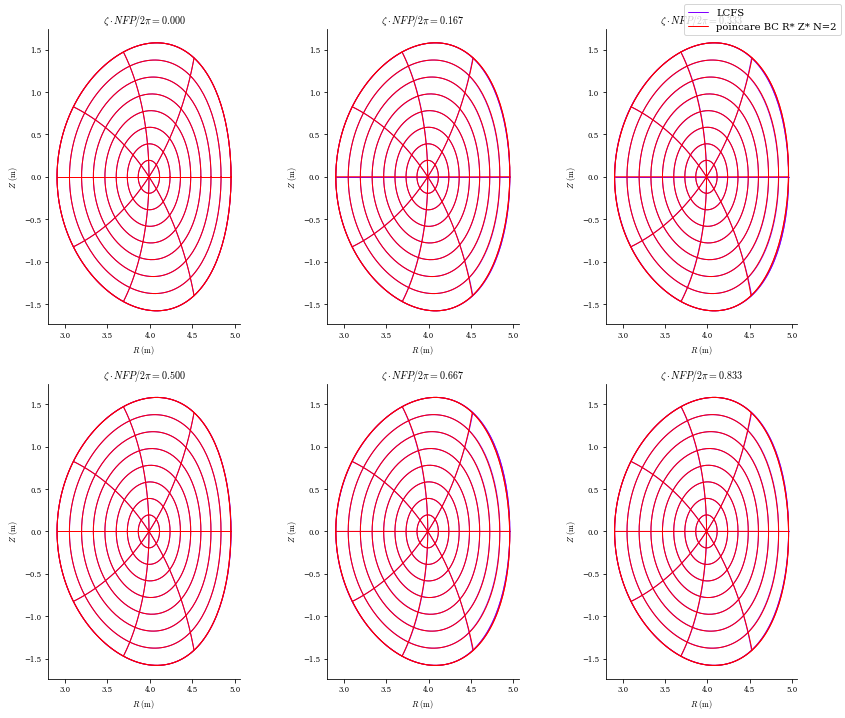

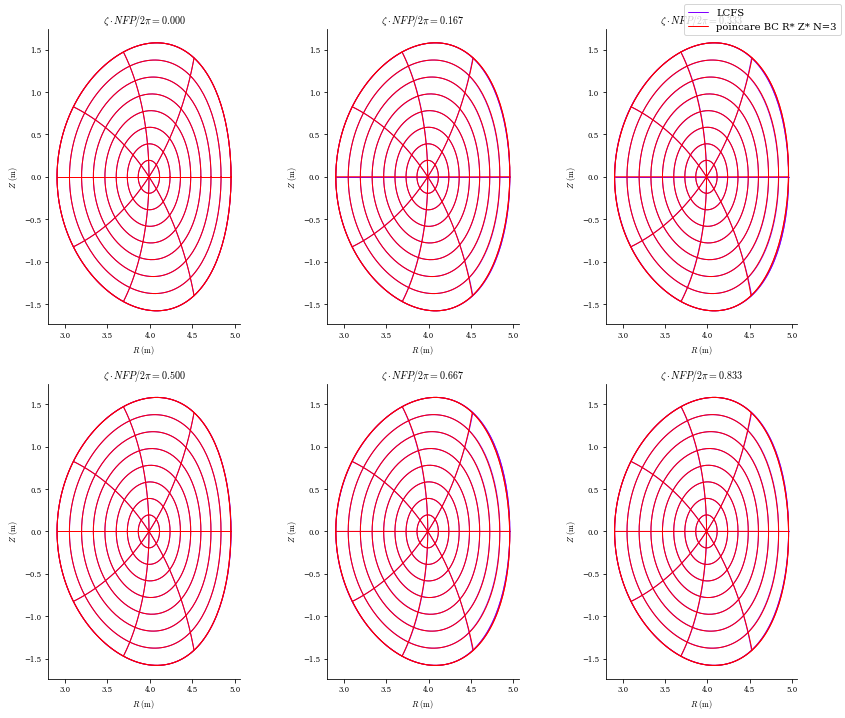

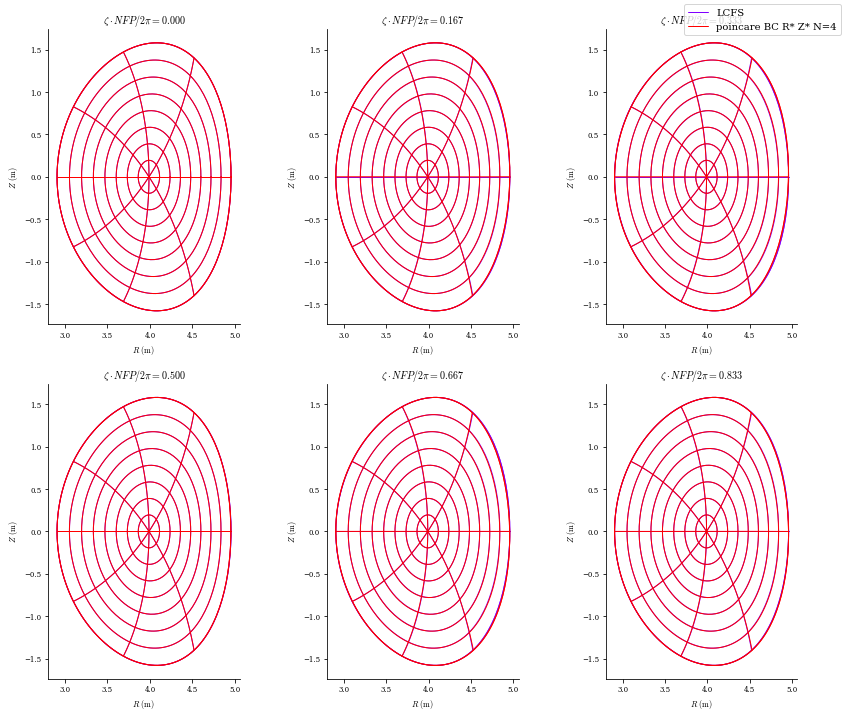

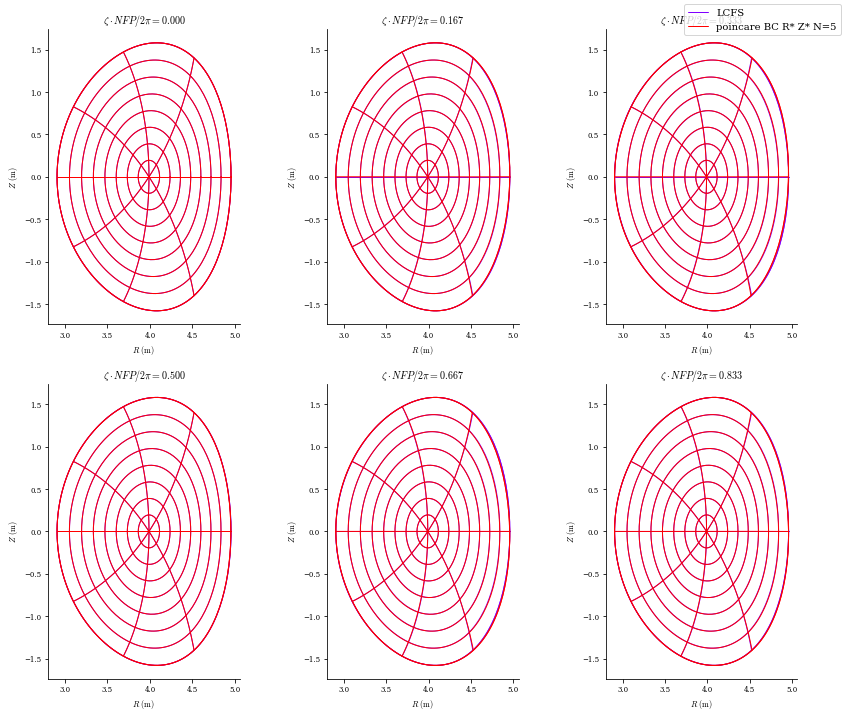

In [5]:
for n in range(2,6):
    eq_poin.change_resolution(eq_poin.L,eq_poin.M,n) # must be certain bases are the same before assigning eq.X_lmn

    constraints = (
        PoincareBoundaryR(),
        PoincareBoundaryZ(),
        LambdaPoincare(),
        LambdaGauge(),
        FixedPressure(),
        FixedIota(),
        FixedPsi(),
    )
    objectives = (RadialForceBalance(), HelicalForceBalance())
    obj = ObjectiveFunction(objectives,constraints)
    eq_poin.solve(verbose=3, ftol=1e-6,objective=obj,maxiter=200,xtol=1e-8);
    plot_comparison(eqs=[eq,eq_poin],labels=['LCFS',f'poincare BC R* Z* N={n}'])

(<Figure size 720x720 with 3 Axes>,
 array([<AxesSubplot:title={'center':'$\\zeta \\cdot NFP/2\\pi = 0.000$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <AxesSubplot:title={'center':'$\\zeta \\cdot NFP/2\\pi = 0.500$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <AxesSubplot:title={'center':'$\\zeta \\cdot NFP/2\\pi = 1.000$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>],
       dtype=object))

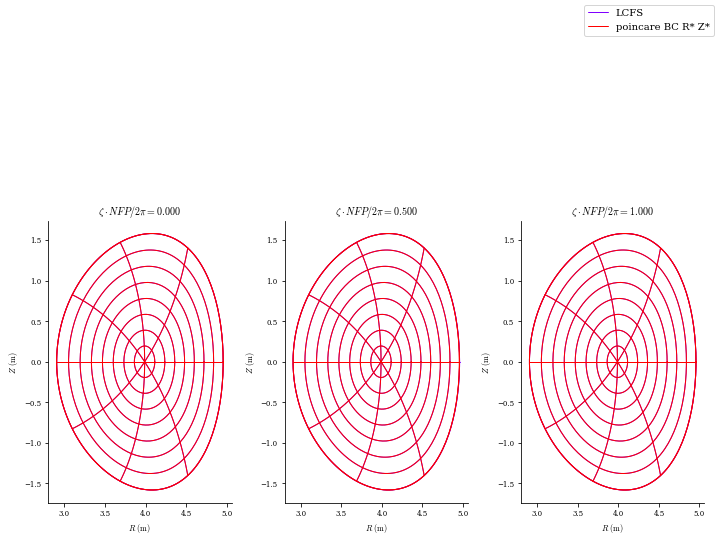

In [6]:
plot_comparison(eqs=[eq,eq_poin],labels=['LCFS','poincare BC R* Z*'],zeta=3,figsize=(10,10))


In [7]:
eq_poin

Equilibrium at 0x7fc12876e490 (L=24, M=12, N=5, NFP=1.0, sym=True, spectral_indexing=fringe)

(<Figure size 288x288 with 2 Axes>,
 <AxesSubplot:title={'center':'$\\lambda~(rad)$'}, xlabel='$\\theta$', ylabel='$\\rho$'>)

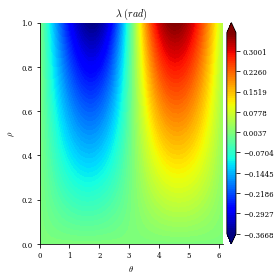

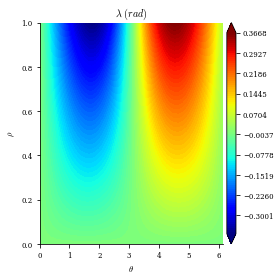

In [8]:
from desc.grid import LinearGrid
plot_2d(eq=eq,name='lambda',grid=LinearGrid(L=50,M=50,zeta=0))
plot_2d(eq=eq_poin,name='lambda',grid=LinearGrid(L=50,M=50,zeta=0))


(<Figure size 864x720 with 6 Axes>,
 array([<AxesSubplot:title={'center':'$\\zeta \\cdot NFP/2\\pi = 0.000$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <AxesSubplot:title={'center':'$\\zeta \\cdot NFP/2\\pi = 0.167$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <AxesSubplot:title={'center':'$\\zeta \\cdot NFP/2\\pi = 0.333$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <AxesSubplot:title={'center':'$\\zeta \\cdot NFP/2\\pi = 0.500$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <AxesSubplot:title={'center':'$\\zeta \\cdot NFP/2\\pi = 0.667$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <AxesSubplot:title={'center':'$\\zeta \\cdot NFP/2\\pi = 0.833$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>],
       dtype=object))

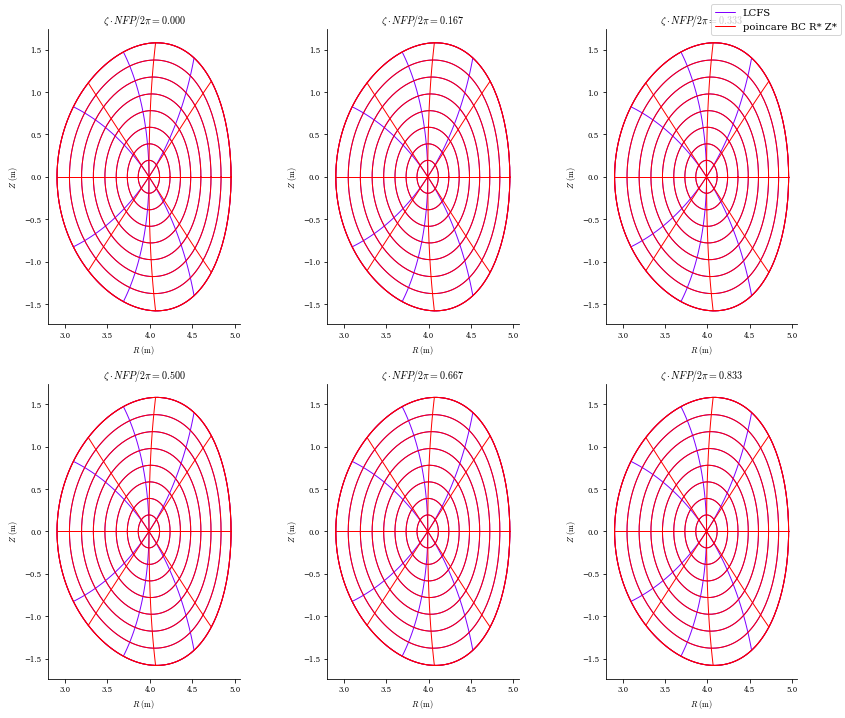

In [18]:
# now do it without lambda constraint
eq = EquilibriaFamily.load(load_from='../examples/DESC/SOLOVEV_output.h5')[-1]
# eq = EquilibriaFamily.load(load_from='SOLOVEV/SOLOVEV_simple_output.h5')[-1] # does it not properly enforce if the constraint would be higher F err? does not seem to make sense...

eq_poin2 = get_eq_poin(eq)
eq_poin2.change_resolution(eq_poin.L,eq_poin.M,1) # must be certain bases are the same before assigning eq.X_lmn
plot_comparison(eqs=[eq,eq_poin2],labels=['LCFS','poincare BC R* Z*'])

Building constraint: poincare R
Building constraint: poincare Z
Building constraint: lambda gauge
Building constraint: fixed-pressure
Building constraint: fixed-iota
Building constraint: fixed-Psi
Building objective: radial force
Precomputing transforms
Timer: Precomputing transforms = 346 ms
Building objective: helical force
Precomputing transforms
Timer: Precomputing transforms = 283 ms
Building linear constraints
Timer: linear constraint build = 8.24 ms
Timer: Objecive build = 1.17 sec
Compiling objective function and derivatives
Timer: Objective compilation time = 4.68 sec
Timer: Jacobian compilation time = 12.4 sec
Timer: Total compilation time = 17.1 sec
Starting optimization
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         4.6561e+09                                    2.97e+10    
       1              2         1.5910e+08      4.50e+09       5.27e+00       7.66e+09    
       2              3         4.23

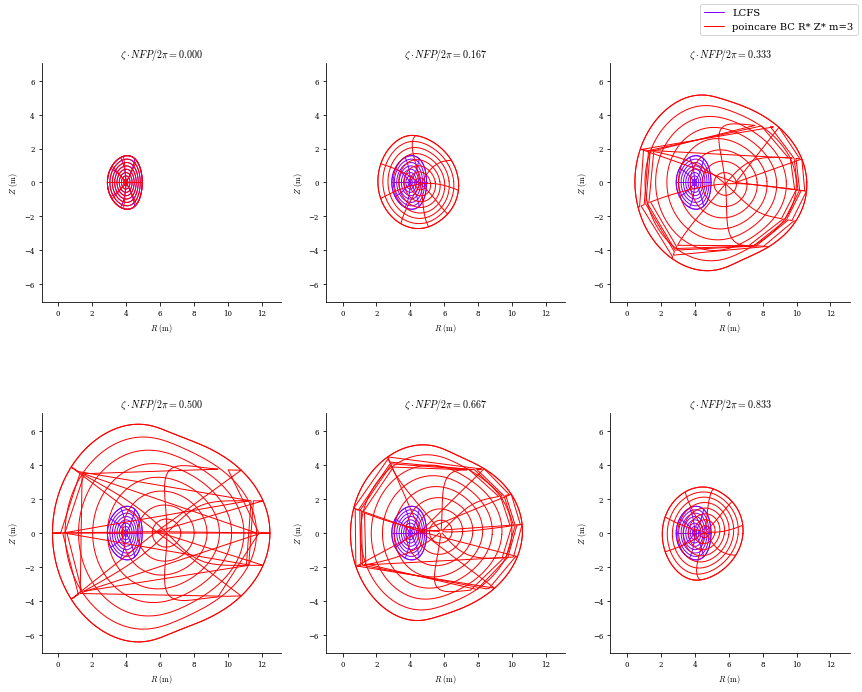

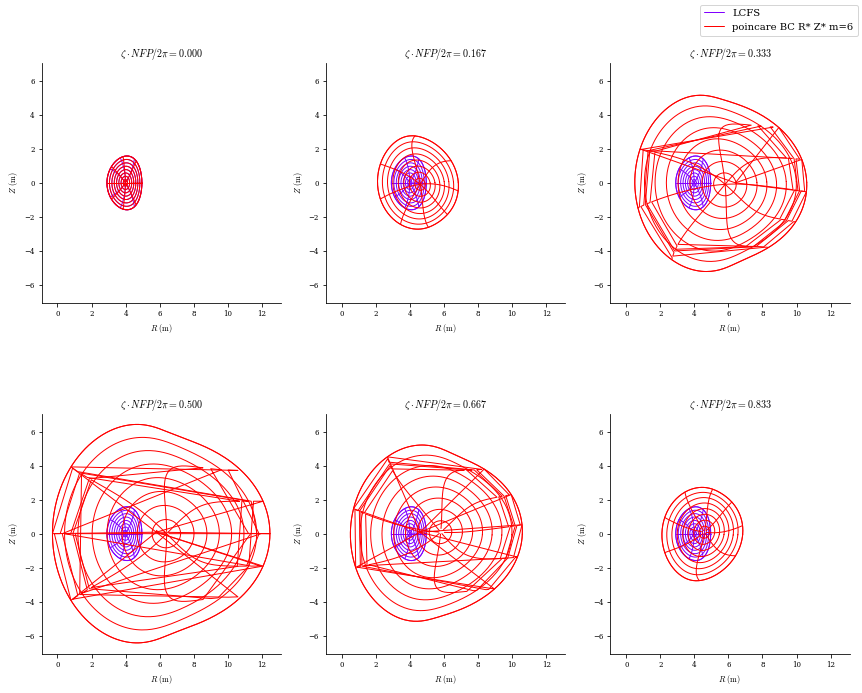

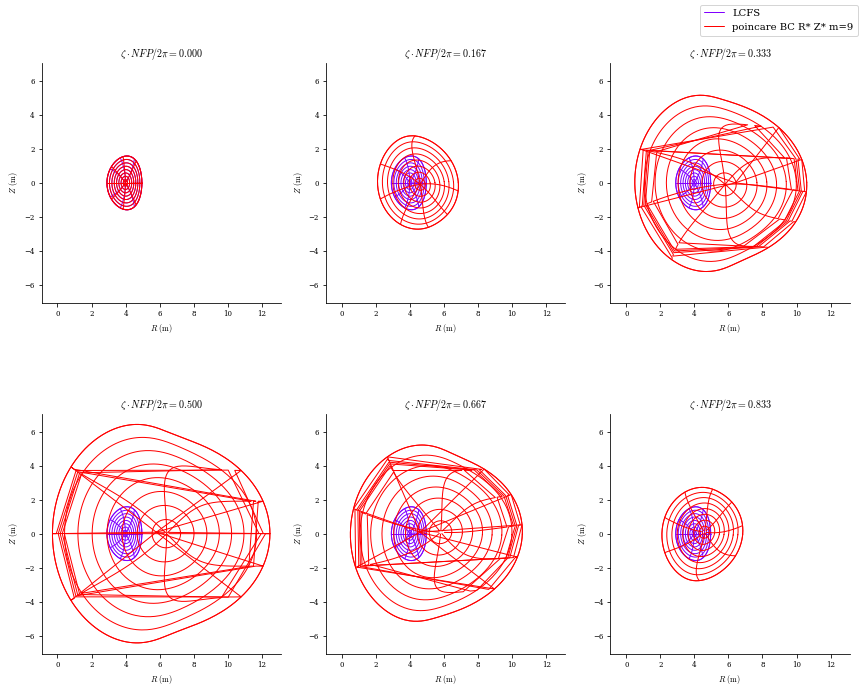

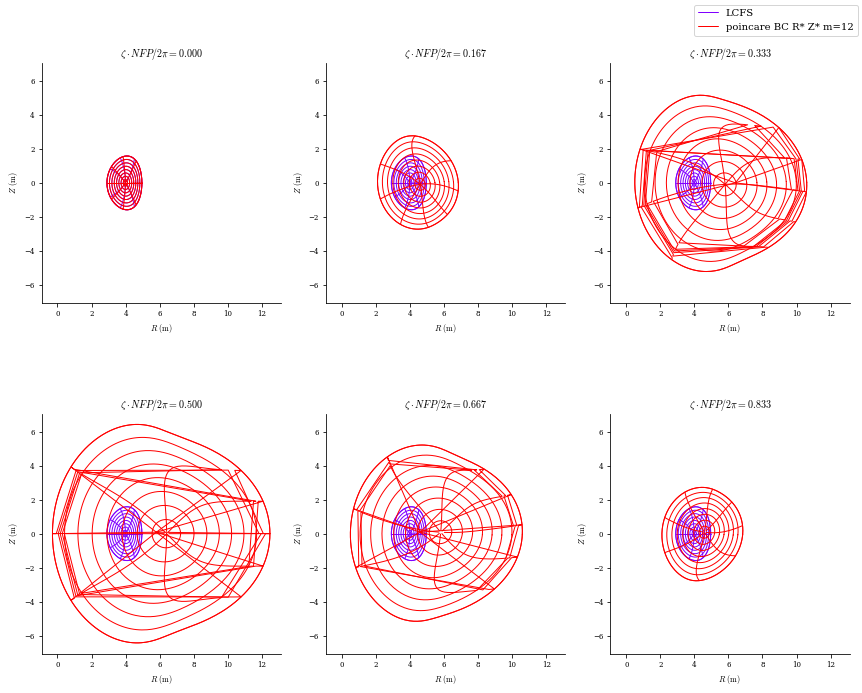

In [19]:
for m in [3,6,9,12]:
    eq_poin2.change_resolution(2*m,m,1)
    constraints = (
        PoincareBoundaryR(),
        PoincareBoundaryZ(),
    #     LambdaPoincare(),
        LambdaGauge(),
        FixedPressure(),
        FixedIota(),
        FixedPsi(),
    )
    objectives = (RadialForceBalance(), HelicalForceBalance())
    obj = ObjectiveFunction(objectives,constraints)
    eq_poin2.solve(verbose=3, ftol=1e-4,objective=obj,maxiter=100);
    plot_comparison(eqs=[eq,eq_poin2],labels=['LCFS',f'poincare BC R* Z* m={m}'])

(<Figure size 720x720 with 6 Axes>,
 array([<AxesSubplot:title={'center':'$\\zeta \\cdot NFP/2\\pi = 0.000$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <AxesSubplot:title={'center':'$\\zeta \\cdot NFP/2\\pi = 0.200$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <AxesSubplot:title={'center':'$\\zeta \\cdot NFP/2\\pi = 0.400$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <AxesSubplot:title={'center':'$\\zeta \\cdot NFP/2\\pi = 0.600$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <AxesSubplot:title={'center':'$\\zeta \\cdot NFP/2\\pi = 0.800$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <AxesSubplot:title={'center':'$\\zeta \\cdot NFP/2\\pi = 1.000$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>],
       dtype=object))

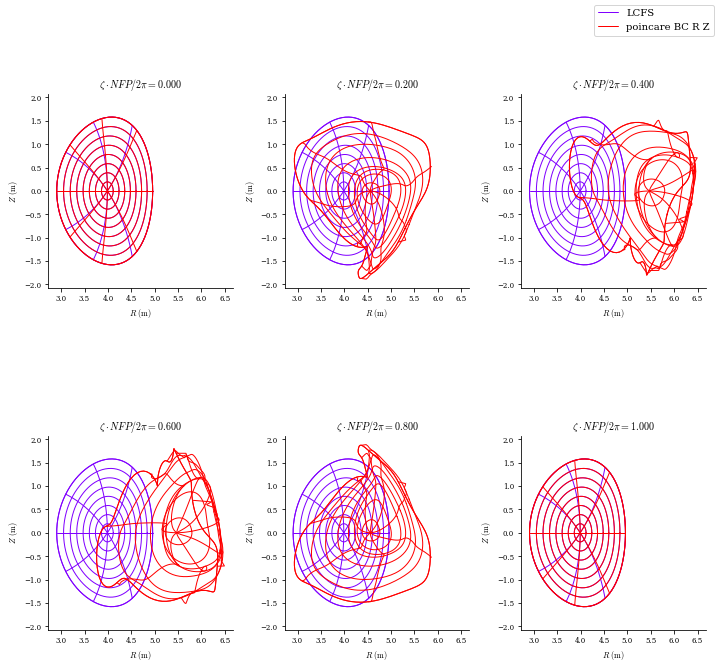

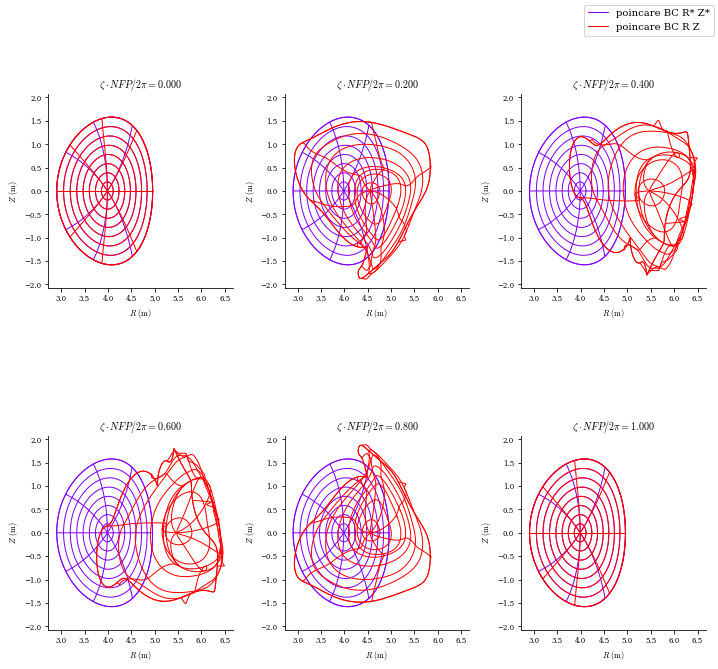

In [11]:
plot_comparison(eqs=[eq,eq_poin2],labels=['LCFS','poincare BC R Z'],zeta=6,figsize=(10,10))
plot_comparison(eqs=[eq_poin,eq_poin2],labels=['poincare BC R* Z*','poincare BC R Z'],zeta=6,figsize=(10,10))
# this takes forever ans also a ton of memory
# leak in plotting somewhere?
# no i think doubled res... so just wa doing like 24 x 24 x 1 thing
# ok this does not work? 

In [12]:
eq_poin2.is_nested()

False

In [13]:
eq

Equilibrium at 0x7fbff41ad3a0 (L=24, M=12, N=1, NFP=1.0, sym=1, spectral_indexing=fringe)